# About the notebook

The data is taken from [this](https://zindi.africa/competitions/farm-pin-crop-detection-challenge) competition. It contains sentinel 2 satellite data including metadata(geospatial data) and raster images. Each image is multispectral and consists of [13 bands](https://en.wikipedia.org/wiki/Sentinel-2) with different spatial resolution which is 10m for the RGB and Nir bands.

In addition it contains shapefiles (train and test) that present agricultural fields. So each row presents a field in a form of a polygon that we know the crop type growing in it (for the train). The crops growing on each field was verified in person and with drones.

Our goal is to build a classification model based on this data to predict the crop type growing in the test shapefile.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/INSPIRE.xml
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/manifest.safe
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/MTD_MSIL1C.xml
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/rep_info/S2_User_Product_Level-1C_Metadata.xsd
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/DATASTRIP/DS_MTI__20170103T030708_S20170101T084543/MTD_DS.xml
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/GRANULE/L1C_T34JFP_A007983_20170101T084543/MTD_TL.xml
/kaggle/input/farm-crop-detection-data/2017-01-01-jfp/S2A_MSIL1C_20170101T08

In [2]:
!pip install rasterio

     |████████████████████████████████| 15.1MB 1.2MB/s 


## Import packages

In [3]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
from rasterio.merge import merge
import geopandas as gdp
from rasterio.mask import mask
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
from shapely.geometry import mapping

import gc
import psutil
import shutil

## Plor RGB and Nir separatly

In [4]:
### Read the different bands: blue/green/red/nir according to the specification of the sentinel 2 data.
raster_01_01_2017_b2_fp = '/kaggle/input/farm-crop-detection-data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B02.jp2'
raster_01_01_2017_b3_fp = '/kaggle/input/farm-crop-detection-data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B03.jp2'
raster_01_01_2017_b4_fp = '/kaggle/input/farm-crop-detection-data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B04.jp2'
raster_01_01_2017_b8_fp = '/kaggle/input/farm-crop-detection-data/2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B08.jp2'

raster_blue = rasterio.open(raster_01_01_2017_b2_fp)
raster_green = rasterio.open(raster_01_01_2017_b3_fp)
raster_red = rasterio.open(raster_01_01_2017_b4_fp)
raster_nir = rasterio.open(raster_01_01_2017_b8_fp)

In [5]:
# Print geospatial properties
print('width: ', raster_blue.width)
print('height: ', raster_blue.height)
print(raster_blue.meta)
print(raster_blue.bounds)
print(raster_blue.read()) ## read it a numpy array

width:  10980
height:  10980
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6900040.0)}
BoundingBox(left=499980.0, bottom=6790240.0, right=609780.0, top=6900040.0)
[[[1261 1293 1328 ... 1560 1584 1588]
  [1253 1278 1314 ... 1535 1548 1566]
  [1254 1294 1332 ... 1531 1557 1561]
  ...
  [1307 1274 1267 ... 1125 1151 1118]
  [1272 1256 1300 ... 1132 1132 1121]
  [   0 1282 1299 ... 1153 1159 1147]]]


In [6]:
# Bands values in numpy arrays
## Crop the raster bands since the image is too big 
dim1 = 4000
dim2 = 8000
dim3 = 2500
red_np = raster_red.read(1)[dim1:dim2,:dim3]
green_np = raster_green.read(1)[dim1:dim2,:dim3]
blue_np = raster_blue.read(1)[dim1:dim2,:dim3]
nir_np = raster_nir.read(1)[dim1:dim2,:dim3]

Text(0.5, 1.0, 'Nir')

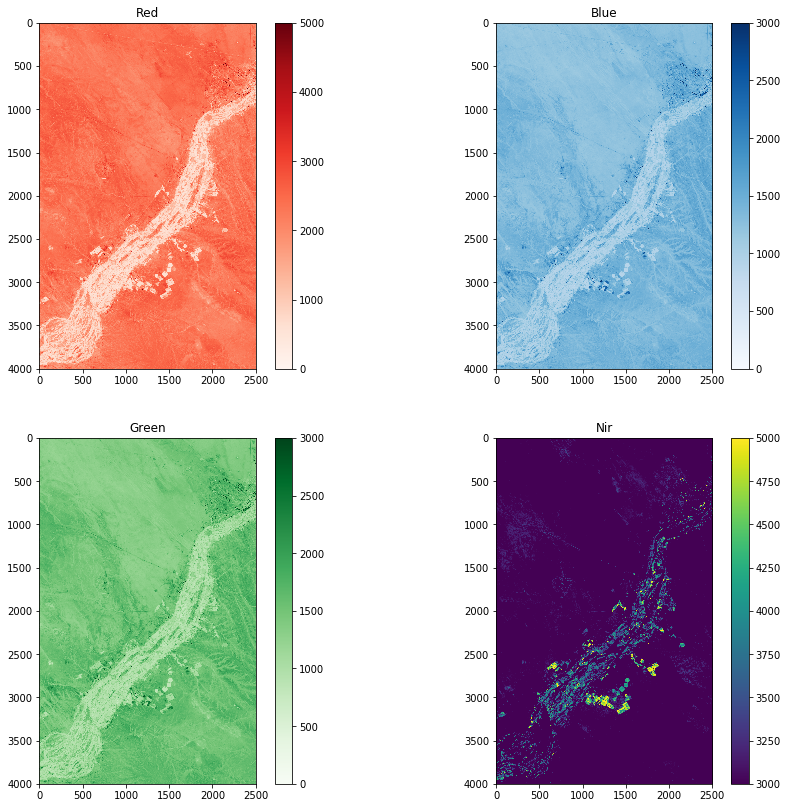

In [7]:
# Initialize subplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 14))
ax1 = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]

# Plot Red, Green, Blue and NIR

# show(raster_red, cmap='Reds',  ax=ax1)
# max_val_red = np.max(red_np) ## maximum value of the red reflectance 
img = ax1.imshow(red_np, cmap = 'Reds')
img.set_clim(vmin=0, vmax=5000) ## set the maximum of the colormap to get better visualisation
fig.colorbar(img, ax = ax1)

## Green
img = ax2.imshow(green_np, cmap = 'Greens')
img.set_clim(vmin=0, vmax=3000)
fig.colorbar(img, ax = ax2)

## Blue
img = ax3.imshow(blue_np, cmap = 'Blues')
img.set_clim(vmin=0, vmax=3000)
fig.colorbar(img, ax = ax3)

### NIR
img = ax4.imshow(nir_np)
img.set_clim(vmin=3000, vmax=5000)
fig.colorbar(img, ax = ax4)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")
ax4.set_title("Nir")

The line in the images is a river and the lands that we want to classify are around that river. 

As expected the red, green and blue values are smaller in the areas of the crop lands since the pigment chlorophyll absorbs visible light to use it in photosynthesis.

And it reflects the near infrared light (nir).

## Plot RGB: True color

In [8]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

(4000, 2500, 3)


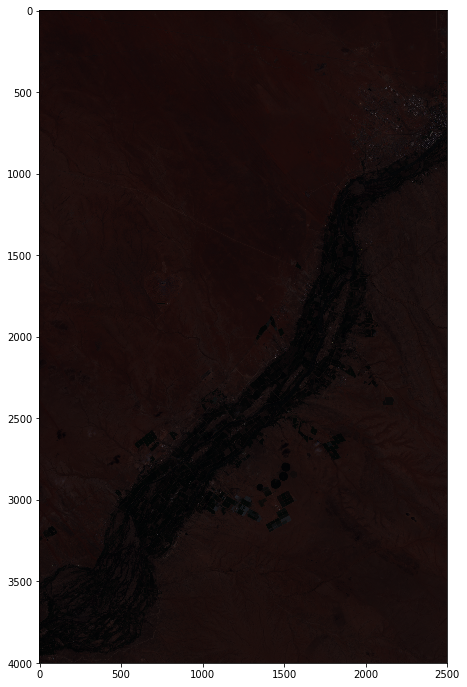

In [9]:
# Normalize the bands
redn = normalize(red_np)
greenn = normalize(green_np)
bluen = normalize(blue_np)
nirn = normalize(nir_np)

# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))
print(rgb.shape)

fig, ax = plt.subplots(figsize = (15,12))
img = ax.imshow(rgb)

## False Color image

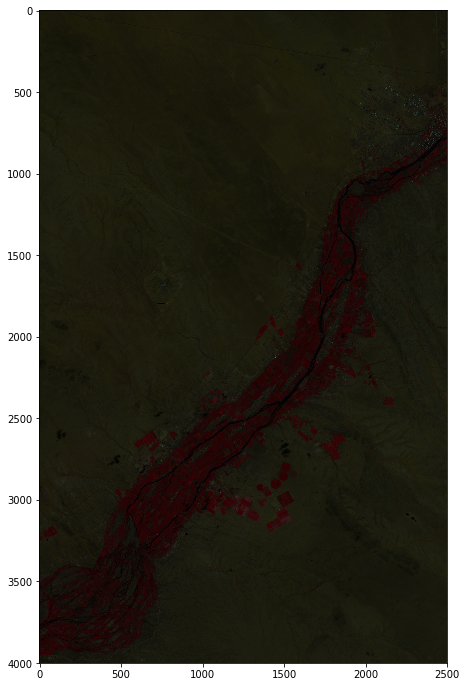

In [10]:
# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

fig, ax = plt.subplots(figsize = (15,12))
img = ax.imshow(nrg)

So here the regions containing vegetations appear in shades of red.

## NDVI 

The Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation frequently used to analyze ecological remote sensing data. NDVI indicates whether the remotely-sensed target contains live green vegetation. When sunlight strikes objects, certain wavelengths of the electromagnetic spectrum are absorbed and other wavelengths are reflected. **The pigment chlorophyll in plant leaves strongly absorbs visible light** (with wavelengths in the range of 400-700 nm) for use in photosynthesis. The cell structure of the leaves, however, **strongly reflects near-infrared light** (wavelengths ranging from 700 - 1100 nm). Plants reflect up to 60% more light in the near infrared portion of the spectrum than they do in the green portion of the spectrum. By calculating the ratio of Near Infrared (NIR) to Visible (VIS) bands in hyperspectral data, we can obtain a metric of vegetation density and health.

0.8312863606981254
-0.38060449792293366


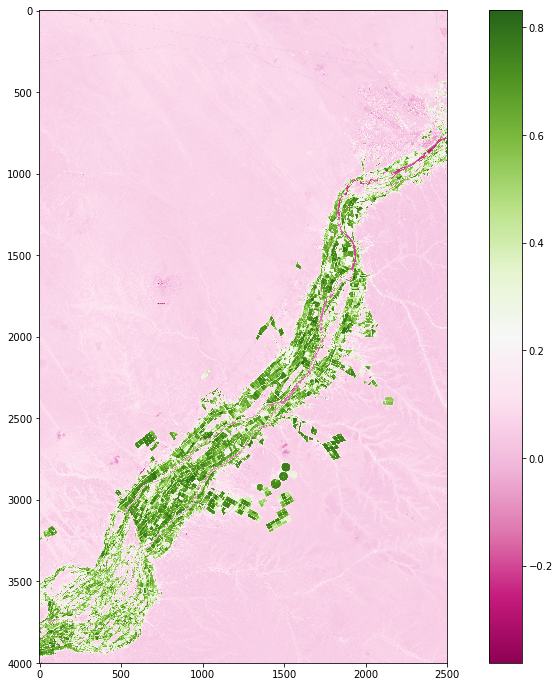

In [11]:
ndvi = (nir_np.astype(float)-red_np.astype(float))/(nir_np.astype(float)+red_np.astype(float))
print(ndvi.max())
print(ndvi.min())

fig, ax = plt.subplots(figsize = (15, 12))
img = ax.imshow(ndvi, cmap = 'PiYG')
# img.set_clim(vmin=20, vmax=70)
fig.colorbar(img, ax = ax)

## Create mosaic raster from two parts

The data is divided to two raster images so we can create a mosaic from the two rasters.

In [12]:
def create_mosaic(fp_bands, sp_bands, date, directory = ''):
    """
    This function creates a mosaic from two raster images and saves it to the directory with the name Mosaic_"+ date+ ".tiff.
    The mosaic will have a number of bands equal to the ones specified in the fp_bands.
    fp_bands: list:
    list of first raster bands that we use to construct the first raster
    sp_bands: list:
    list of the second raster bands that we use to construct the second raster
    date: string:
    the date of the raster, we use it to name the final registered the mosaic
    """
    
    if(len(fp_bands) == 0 or len(sp_bands)== 0):
        print('There are no bands')
        return 0
    if(len(fp_bands) != len(sp_bands)):
        print('The length of the two bands lists are not equal')
        return 0
    
    ## set the first part of the mosaic image
    nb_bands = len(fp_bands)
    with rasterio.open(fp_bands[0]) as src0:
        fb_meta = src0.meta

    fb_meta['driver'] = 'Gtiff'
    fb_meta['count'] = nb_bands
    
    #export true color image
    with rasterio.open('first_part.tiff', 'w', **fb_meta) as dst:
        for id, layer in enumerate(fp_bands, start=1):
            with rasterio.open(layer) as src1:
                dst.write(src1.read(1), id)

    print('first part completed')
    
    ## set the second part of the mosaic image
    with rasterio.open(sp_bands[0]) as src0:
        sb_meta = src0.meta

    sb_meta['driver'] = 'Gtiff'
    sb_meta['count'] = nb_bands
    
    #export true color image
    with rasterio.open('second_part.tiff', 'w', **sb_meta) as dst:
        for id, layer in enumerate(sp_bands, start=1):
            with rasterio.open(layer) as src1:
                dst.write(src1.read(1), id)
    print('second part completed')
    
    ## Create the mosaic
    first_part = rasterio.open(r"first_part.tiff", count=nb_bands)
    second_part = rasterio.open(r"second_part.tiff", count=nb_bands)

    src_files_to_mosaic = [first_part, second_part]  
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    out_meta = sb_meta.copy()
    out_meta.update({"height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": out_trans})
    
    out_fp = r"Mosaic_"+ date+ ".tiff"
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)
        
        
    first_part.close()
    second_part.close()
    os.remove(r"./first_part.tiff")
    os.remove(r"./second_part.tiff")
    gc.collect()
    print('mosaic is created and saved')

In [13]:
### 2017-01-01 mosaic
parent_path = '/kaggle/input/farm-crop-detection-data/'

raster_b2_fp = os.path.join(parent_path, '2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B02.jp2')
raster_b3_fp = os.path.join(parent_path, '2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B03.jp2')
raster_b4_fp = os.path.join(parent_path, '2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B04.jp2')
raster_b8_fp = os.path.join(parent_path, '2017-01-01/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_B08.jp2')
fp_bands = [raster_b2_fp, raster_b3_fp, raster_b4_fp, raster_b8_fp]


raster_jfp_b2_fp = os.path.join(parent_path, '2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/GRANULE/L1C_T34JFP_A007983_20170101T084543/IMG_DATA/T34JFP_20170101T082332_B02.jp2')
raster_jfp_b3_fp = os.path.join(parent_path, '2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/GRANULE/L1C_T34JFP_A007983_20170101T084543/IMG_DATA/T34JFP_20170101T082332_B03.jp2')
raster_jfp_b4_fp = os.path.join(parent_path, '2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/GRANULE/L1C_T34JFP_A007983_20170101T084543/IMG_DATA/T34JFP_20170101T082332_B04.jp2')
raster_jfp_b8_fp = os.path.join(parent_path, '2017-01-01-jfp/S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE/GRANULE/L1C_T34JFP_A007983_20170101T084543/IMG_DATA/T34JFP_20170101T082332_B08.jp2')
sp_bands = [raster_jfp_b2_fp, raster_jfp_b3_fp, raster_jfp_b4_fp, raster_jfp_b8_fp]

In [14]:
date = "2017-01-01"
create_mosaic(fp_bands, sp_bands, date)
raster = rasterio.open(r"Mosaic_"+ date+ ".tiff", count=4)

first part completed
second part completed
mosaic is created and saved


## Histogram of the raster data

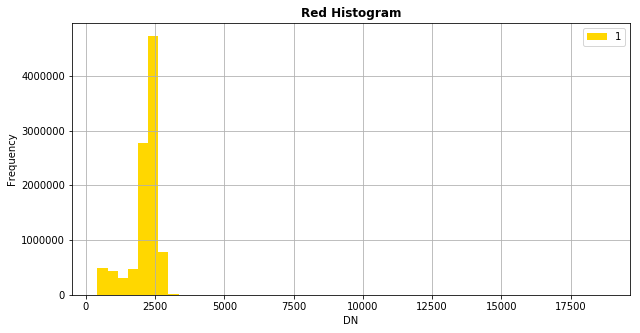

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(red_np, bins=50, lw=0.0, histtype='stepfilled', title="Red Histogram")

In [16]:
# fig, ax = plt.subplots(figsize=(10,5))
# show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
#       histtype='stepfilled', title="Histogram")

## plot shapefile with raster

In [17]:
### Read shapefile
train = gdp.read_file('/kaggle/input/crop-detection-challenge-additional-data/train/train/train.shp')
train.dropna(subset=['geometry'], inplace = True)
train.reset_index(drop=True, inplace= True)
train.head()

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,POLYGON ((2467881.175041331 -3352032.059296422...
1,2,2.064410,3,6,"POLYGON ((2468428.90623293 -3351993.17305059, ..."
2,3,1.080300,3,8,POLYGON ((2468333.745293362 -3352058.485056543...
3,4,1.316190,3,8,POLYGON ((2468607.857733211 -3352012.337531495...
4,7,5.529220,3,8,"POLYGON ((2468646.08520868 -3351706.201920062,..."


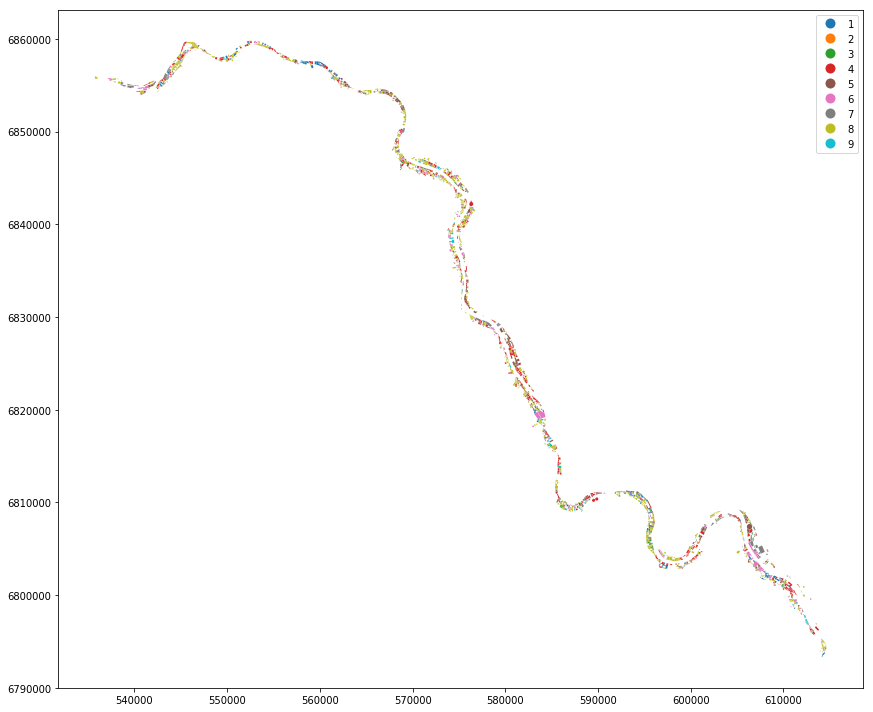

In [18]:
## Change the train crs as the raster image one.
train  = train.to_crs(raster.crs.data)
### Plot the polygons with the class of each one
train.plot(column='Crop_Id_Ne', linewidth=2, figsize=(20,10), legend = True)
plt.tight_layout()